In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from collections import Counter

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    # TODO add data agumentation here
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

data_path = 'realwaste-main/RealWaste'
model_path = 'models/model.pth'
dataset = datasets.ImageFolder(root=data_path, transform=transform)


dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

n_classes = len(dataset.classes)
images, labels = next(iter(dataloader))

In [15]:
print(dataset.classes)

['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


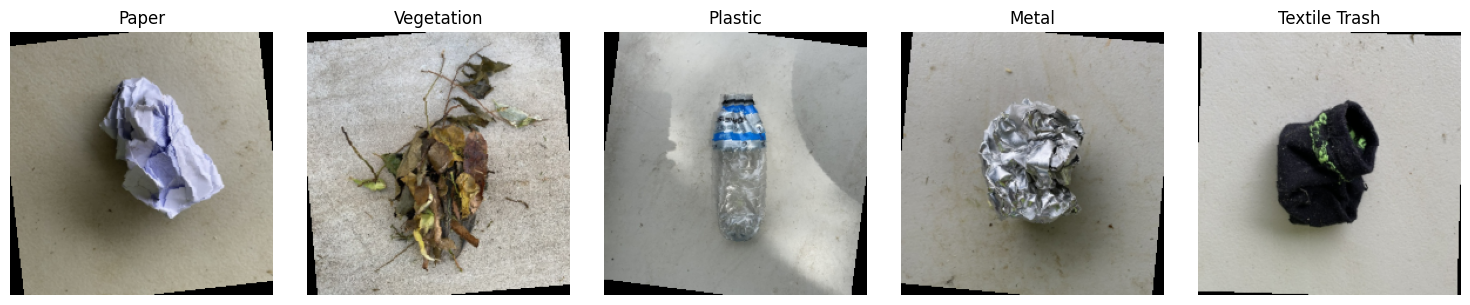

In [2]:
import matplotlib.pyplot as plt


# Let's show the first 5 images
num_images = 5
fig, axs = plt.subplots(1, num_images, figsize=(15, 3))  # 1 row, N columns
class_names = dataset.classes 
for i in range(num_images):
    img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    img = img * 0.5 + 0.5             # Undo normalization if applied
    
    axs[i].imshow(img)
    axs[i].set_title(class_names[labels[i]])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# split the dataset into train-eval-test with 70:10:20 ratio
from torch.utils.data import WeightedRandomSampler

dataset_len = len(dataset)
train_len = int(0.7*dataset_len)
eval_len = int(.1*dataset_len)

test_len= int(dataset_len - train_len - eval_len)

train_set,eval_set, test_set = random_split(dataset,[train_len,eval_len,test_len])



label_counts = [0]*n_classes
for i in train_set.indices:
    label = dataset.targets[i]
    label_counts[label] += 1
num_classes = len(label_counts)
total = len(train_set)
weights = [total / ( num_classes* label_counts[cls]) for cls in range(num_classes)]

label_weights = [weights[dataset.targets[i]] for i in train_set.indices]
# Create a weighted sampler
sampler = WeightedRandomSampler(label_weights, total, replacement=True)

train_loader = DataLoader(train_set, batch_size=32, sampler=sampler)
eval_loader = DataLoader(eval_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

len(train_loader),len(eval_loader), len(test_loader)

(104, 15, 30)

In [3]:
import torchvision.models as models

# Example: Load a pre-trained ResNet18
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

/Users/akayouadanekitessa/Documents/Fordham_classes/ML/project/.waste_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/akayouadanekitessa/Documents/Fordham_classes/ML/project/.waste_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
head = torch.nn.Linear(resnet18.fc.in_features, n_classes)
# Replace the last layer with a new one
resnet18.fc = head

In [5]:
from  helper import EarlyStopping
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = resnet18.to(device)

# for param in model.parameters():
#     param.requires_grad = False
    
# for param in model.fc.parameters():
#     param.requires_grad = True

In [6]:
# define the loss and optimizer
from torch.nn import CrossEntropyLoss
from  torch.optim import Adam


criterion = CrossEntropyLoss()
optimizer =Adam(model.parameters(), lr=0.0001)
early_stopping = EarlyStopping(path=model_path,patience=7, delta=0.01)


In [18]:
import helper

trainer = helper.Trainer(model=model, 
                         criterion=criterion, 
                         optimizer=optimizer, 
                         early_stopping=early_stopping,
                         device=device)
model = trainer.train(train_loader=train_loader,
                      eval_loader=eval_loader,
                      n_epochs=1)

100%|██████████| 1/1 [00:21<00:00, 21.85s/it]

116.22315835952759 13.198587954044342


In [10]:
from tqdm import tqdm 
# train here
n_epochs = 100

for i in tqdm(range(n_epochs)):
    train_loss = 0
    model.train()

    for input,target in train_loader:
        input = input.to(device)
        target = target.to(device)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(input)

        # calculate loss
        loss = criterion(outputs,target)
        train_loss +=loss.item()
        # backpropagation 
        loss.backward()
        optimizer.step()


    
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for input,target in eval_loader:
            input = input.to(device)
            target = target.to(device)
            
            # forward pass
            outputs = model(input)

            loss = criterion(outputs,target)
            eval_loss+=loss.item()
            # check for early stopping
    
    early_stopping(eval_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # eval 
    print(train_loss,eval_loss)


  1%|          | 1/100 [00:48<1:19:58, 48.47s/it]

85.33873243629932 9.001317799091339


  2%|▏         | 2/100 [01:24<1:07:12, 41.15s/it]

36.91267787665129 6.859821140766144


  3%|▎         | 3/100 [02:01<1:03:11, 39.08s/it]

20.954837542027235 4.8777100294828415


  4%|▍         | 4/100 [02:37<1:01:03, 38.16s/it]

13.171711791306734 4.911358132958412


  5%|▌         | 5/100 [03:15<1:00:14, 38.05s/it]

10.739399400539696 5.711962878704071


  6%|▌         | 6/100 [03:52<59:04, 37.71s/it]  

8.545856818556786 4.753773709759116


  7%|▋         | 7/100 [04:34<1:00:14, 38.87s/it]

7.574730550870299 4.441900290548801


  8%|▊         | 8/100 [05:08<57:41, 37.63s/it]  

4.348676074296236 4.3849732130765915


  9%|▉         | 9/100 [05:43<55:39, 36.70s/it]

3.403374154586345 4.113552048802376


 10%|█         | 10/100 [06:17<53:54, 35.94s/it]

5.194599788635969 4.993951551616192


 11%|█         | 11/100 [06:52<52:42, 35.54s/it]

5.775346389040351 4.9553917944431305


 12%|█▏        | 12/100 [07:26<51:32, 35.14s/it]

3.7066962358076125 5.705679997801781


 13%|█▎        | 13/100 [08:01<50:45, 35.00s/it]

4.018603945616633 4.249937415122986


 14%|█▍        | 14/100 [08:36<50:15, 35.07s/it]

3.2000849918695167 4.003875009715557


 15%|█▌        | 15/100 [09:11<49:31, 34.95s/it]

2.235793143627234 3.668033007532358


 16%|█▌        | 16/100 [09:45<48:37, 34.74s/it]

2.987534331972711 4.092798829078674


 17%|█▋        | 17/100 [10:19<47:42, 34.49s/it]

4.251878502778709 6.411186633631587


 18%|█▊        | 18/100 [10:54<47:10, 34.51s/it]

2.7751427381299436 5.822819396853447


 19%|█▉        | 19/100 [11:27<46:20, 34.32s/it]

2.3140894300304353 5.165054008364677


 20%|██        | 20/100 [12:02<45:42, 34.28s/it]

2.8399717296706513 4.305952472612262


 21%|██        | 21/100 [12:36<45:01, 34.20s/it]

3.5217916736146435 5.690278057008982


 21%|██        | 21/100 [13:10<49:34, 37.65s/it]

Early stopping


In [11]:
# load the best model
model.load_state_dict(torch.load(model_path))
model.eval(), model_path

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [20]:
print(model)

<All keys matched successfully>


In [12]:
# test here
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
y_true = []
y_pred = [] 
model.eval()    
with torch.no_grad():
    for input,target in test_loader:
        input = input.to(device)
        target = target.to(device)
        
        # forward pass
        outputs = model(input)
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Classification report
report = classification_report(y_true, y_pred, target_names=dataset.classes)
print(report)
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


Accuracy: 91.38%
                     precision    recall  f1-score   support

          Cardboard       0.97      0.92      0.94        98
      Food Organics       0.93      0.97      0.95        94
              Glass       0.96      0.93      0.94        83
              Metal       0.89      0.93      0.91       156
Miscellaneous Trash       0.86      0.79      0.83       102
              Paper       0.88      0.93      0.91        88
            Plastic       0.92      0.90      0.91       172
      Textile Trash       0.86      0.91      0.89        69
         Vegetation       0.96      0.96      0.96        89

           accuracy                           0.91       951
          macro avg       0.91      0.92      0.91       951
       weighted avg       0.91      0.91      0.91       951

Confusion Matrix:
[[ 90   0   0   2   0   3   2   1   0]
 [  0  91   1   0   0   0   0   0   2]
 [  0   0  77   3   1   0   2   0   0]
 [  0   0   0 145   3   0   6   2   0]
 [  1   1   0

<Axes: >

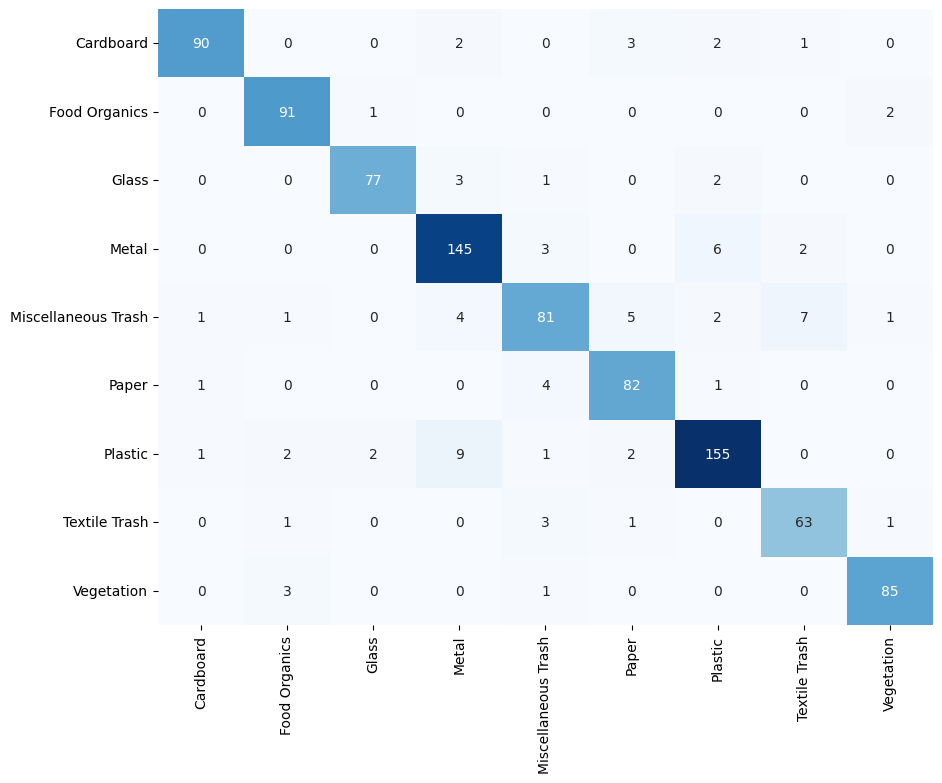

In [13]:
# visualize the test results here
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=dataset.classes, columns=dataset.classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)           